In [13]:
import numpy as np
import datetime
from netCDF4 import Dataset
import itertools
import matplotlib.pyplot as plt
from matplotlib import gridspec
import tqdm
from scipy.stats import linregress
import warnings
warnings.filterwarnings("ignore")

In [14]:
# create days and dates list from 01/10/2010 - 30/04/2011
days_short = np.arange(0,212)
dates_short = [datetime.date(2010,10,1)+datetime.timedelta(days=np.int(days)) for days in days_short]
doys_short = np.array([x.timetuple().tm_yday for x in dates_short])
# create days and dates list from 01/01/2010 - 30/04/2021
days_long = np.arange(0,4138)
dates_long = [datetime.date(2010,1,1)+datetime.timedelta(days=np.int(days)) for days in days_long]
doys_long = np.array([x.timetuple().tm_yday for x in dates_long])

In [15]:
snow = 'SMLG_ERA5'

### load buoy data and create buoy climatology

In [16]:
datapath = '/Users/carmennab/Dropbox/alpha_retracker/data/validation/BGEP/'
bgep_a = np.asarray(Dataset(datapath+'ULS_A/'+snow+'_SIT_EASE_01Jan2010-31Jul2021.nc')['Sea Ice Thickness'])[:4138]
bgep_b = np.asarray(Dataset(datapath+'ULS_B/'+snow+'_SIT_EASE_01Jan2010-31Jul2021.nc')['Sea Ice Thickness'])[:4138]
bgep_d = np.asarray(Dataset(datapath+'ULS_D/'+snow+'_SIT_EASE_01Jan2010-31Jul2021.nc')['Sea Ice Thickness'])[:4138]

In [17]:
days = np.arange(0,367)
buoya_avs = np.array([np.nanmean(bgep_a[doys_long==day]) for day in days])
buoyb_avs = np.array([np.nanmean(bgep_b[doys_long==day]) for day in days])
buoyd_avs = np.array([np.nanmean(bgep_d[doys_long==day]) for day in days])

buoya_anoms = np.array([buoy-buoya_avs[doy] for doy,buoy in zip(doys_long,bgep_a)])
buoyb_anoms = np.array([buoy-buoyb_avs[doy] for doy,buoy in zip(doys_long,bgep_b)])
buoyd_anoms = np.array([buoy-buoyd_avs[doy] for doy,buoy in zip(doys_long,bgep_d)])

buoy_anoms = np.concatenate((buoya_anoms,buoyb_anoms,buoyd_anoms),axis = 0)

### calculate optimal alpha for full season

In [18]:
datapath = '/Users/carmennab/Dropbox/alpha_retracker/data/sit/'
names = ['CPOM','AWI']
alphas = np.arange(0,101)
all_rs = {}

for name in names:
    rs = np.full(101,np.nan)
    for alpha in alphas:
        a = np.asarray(Dataset(datapath+snow+'_'+name+'/ULS_A/a'+str(alpha)+'.nc')['Sea Ice Thickness'])
        b = np.asarray(Dataset(datapath+snow+'_'+name+'/ULS_B/a'+str(alpha)+'.nc')['Sea Ice Thickness'])
        d = np.asarray(Dataset(datapath+snow+'_'+name+'/ULS_D/a'+str(alpha)+'.nc')['Sea Ice Thickness'])

        ### create daily climatology for cs2
        cs2a_avs = np.array([np.nanmean(a[doys_long==day]) for day in days])
        cs2b_avs = np.array([np.nanmean(b[doys_long==day]) for day in days])
        cs2d_avs = np.array([np.nanmean(d[doys_long==day]) for day in days])
        
        cs2a_anoms = np.array([cs2-cs2a_avs[doy] for doy,cs2 in zip(doys_long,a)])
        cs2b_anoms = np.array([cs2-cs2b_avs[doy] for doy,cs2 in zip(doys_long,b)])
        cs2d_anoms = np.array([cs2-cs2d_avs[doy] for doy,cs2 in zip(doys_long,d)])
        
        ### create daily anomalies for cs2
        cs2_anoms = np.concatenate((cs2a_anoms,cs2b_anoms,cs2d_anoms),axis = 0) 
        
        ### calculate alpha
        mask = ~np.isnan(buoy_anoms) & ~np.isnan(cs2_anoms)
        
        rstats = linregress(buoy_anoms[mask],cs2_anoms[mask]) 
        p = rstats.pvalue
        if p <=0.05:
            rs[alpha] = rstats.rvalue
            
    rs[rs<0] = np.nan
    all_rs[name] = rs

In [19]:
ns = []
all_mask = np.where((~np.isnan(buoy_anoms)) & (~np.isnan(cs2_anoms)))
ns.append(buoy_anoms[mask].shape[0])
ns

[6272]

In [20]:
### calculate mean bias

for name in names:
    alpha = np.nanargmax(all_rs[name])
    a = np.asarray(Dataset(datapath+snow+'_'+name+'/ULS_A/a'+str(alpha)+'.nc')['Sea Ice Thickness'])
    b = np.asarray(Dataset(datapath+snow+'_'+name+'/ULS_B/a'+str(alpha)+'.nc')['Sea Ice Thickness'])
    d = np.asarray(Dataset(datapath+snow+'_'+name+'/ULS_D/a'+str(alpha)+'.nc')['Sea Ice Thickness'])
    
    a_diff = a - bgep_a
    b_diff = b - bgep_b
    d_diff = d - bgep_d
    
    all_diffs = np.concatenate((a_diff,b_diff,d_diff),axis = 0) 
    
    print(name, alpha, np.round(np.nanmean(all_diffs),decimals=2))

CPOM 54 -0.75
AWI 53 -0.95


### calculate optimal alpha over FYI / MYI

In [22]:
datapath = '/Users/carmennab/Dropbox/alpha_retracker/data/icetype/'
it_a = np.array(Dataset(datapath + 'ULS_A.nc')['Ice Type'])
it_b = np.array(Dataset(datapath + 'ULS_B.nc')['Ice Type'])
it_d = np.array(Dataset(datapath + 'ULS_D.nc')['Ice Type'])
icetype = np.concatenate((it_a,it_b,it_d),axis = 0)
icetype.shape

(12414,)

In [23]:
clean_icetypes=icetype.copy()
clean_icetypes[np.isnan(cs2_anoms)] = np.nan
clean_icetypes[np.isnan(buoy_anoms)]=np.nan
clean_icetypes[~np.isnan(clean_icetypes)].shape

(5425,)

In [24]:
fyi_buoys = buoy_anoms.copy()
fyi_buoys[clean_icetypes == 3] = np.nan # remove myi
fyi_buoys[np.isnan(clean_icetypes)] = np.nan
ns.append(fyi_buoys[~np.isnan(fyi_buoys)].shape[0])

myi_buoys = buoy_anoms.copy()
myi_buoys[clean_icetypes == 2] = np.nan # remove fyi
myi_buoys[np.isnan(clean_icetypes)] = np.nan
ns.append(myi_buoys[~np.isnan(myi_buoys)].shape[0])

In [25]:
#### one giant buoy
datapath = '/Users/carmennab/Dropbox/alpha_retracker/data/sit/'
alphas = np.arange(0,101)
all_fyi = {}
all_myi = {}

for name in names:
    rs_fyi = np.full(101,np.nan)
    rs_myi = np.full(101,np.nan)

    for alpha in alphas:
        a = np.asarray(Dataset(datapath+snow+'_'+name+'/ULS_A/a'+str(alpha)+'.nc')['Sea Ice Thickness'])
        b = np.asarray(Dataset(datapath+snow+'_'+name+'/ULS_B/a'+str(alpha)+'.nc')['Sea Ice Thickness'])
        d = np.asarray(Dataset(datapath+snow+'_'+name+'/ULS_D/a'+str(alpha)+'.nc')['Sea Ice Thickness'])

        ### create daily climatology for cs2
        cs2a_avs = np.array([np.nanmean(a[doys_long==day]) for day in days])
        cs2b_avs = np.array([np.nanmean(b[doys_long==day]) for day in days])
        cs2d_avs = np.array([np.nanmean(d[doys_long==day]) for day in days])
        
        cs2a_anoms = np.array([cs2-cs2a_avs[doy] for doy,cs2 in zip(doys_long,a)])
        cs2b_anoms = np.array([cs2-cs2b_avs[doy] for doy,cs2 in zip(doys_long,b)])
        cs2d_anoms = np.array([cs2-cs2d_avs[doy] for doy,cs2 in zip(doys_long,d)])
        
        ### create daily anomalies for cs2
        cs2_anoms = np.concatenate((cs2a_anoms,cs2b_anoms,cs2d_anoms),axis = 0) 

        ### calculate alpha fyi: 
        mask_fyi = ~np.isnan(fyi_buoys) & ~np.isnan(cs2_anoms) 
        rstats = linregress(fyi_buoys[mask_fyi],cs2_anoms[mask_fyi]) 
        p = rstats.pvalue
        if p <=0.05:
            rs_fyi[alpha] = rstats.rvalue
                        
        ### calculate alpha myi:
        mask_myi = ~np.isnan(myi_buoys) & ~np.isnan(cs2_anoms)
        rstats = linregress(myi_buoys[mask_myi],cs2_anoms[mask_myi]) 
        p = rstats.pvalue
        if p <=0.05:
            rs_myi[alpha] = rstats.rvalue
            
    rs_fyi[rs_fyi<0] = np.nan
    rs_myi[rs_myi<0] = np.nan
                        
    all_fyi[name] = rs_fyi
    all_myi[name] = rs_myi

### calculate optimal alpha at different temperatures

In [26]:
datapath = '/Users/carmennab/Dropbox/alpha_retracker/data/temperature/'
temp_a = np.array(Dataset(datapath + 'ERA5_temp_ULS_A.nc')['Air Temperature'])
temp_b = np.array(Dataset(datapath + 'ERA5_temp_ULS_B.nc')['Air Temperature'])
temp_d = np.array(Dataset(datapath + 'ERA5_temp_ULS_D.nc')['Air Temperature'])
temps = np.concatenate((temp_a,temp_b,temp_d),axis = 0)

In [27]:
clean_temps = temps.copy()

clean_buoys = buoy_anoms.copy()
clean_buoys[np.isnan(clean_temps)]=np.nan
clean_buoys[np.isnan(cs2_anoms)]=np.nan

q_temps = clean_temps[~np.isnan(clean_buoys)]
q_temps.shape

(6272,)

In [28]:
q_temps

array([255.77629704, 254.92616869, 255.94049952, ..., 263.45867877,
       263.49125687, 262.07157955])

In [29]:
q = np.quantile(q_temps,q=np.arange(0,1.01,1/3))
q

array([236.78741951, 248.7790751 , 254.45323141, 271.37629462])

In [30]:
q = np.quantile(q_temps,q=np.arange(0,1.01,1/3))

cold_buoys = clean_buoys.copy()
cold_buoys[clean_temps > q[1]] = np.nan 

ns.append(cold_buoys[~np.isnan(cold_buoys)].shape[0])

warm_buoys = clean_buoys.copy()
warm_buoys[clean_temps> q[2]] = np.nan 
warm_buoys[clean_temps< q[1]] = np.nan 

ns.append(warm_buoys[~np.isnan(warm_buoys)].shape[0])

hot_buoys = clean_buoys.copy()
hot_buoys[clean_temps < q[2]] = np.nan 
hot_buoys[clean_temps > q[3]] = np.nan 

ns.append(hot_buoys[~np.isnan(hot_buoys)].shape[0])

In [16]:
#### one giant buoy
datapath = '/Users/carmennab/Dropbox/alpha_retracker/data/sit/'
alphas = np.arange(0,101)
all_hot = {}
all_warm = {}
all_cold = {}

for name in names:
    rs_hot = np.full(101,np.nan)
    rs_warm = np.full(101,np.nan)
    rs_cold = np.full(101,np.nan)
    for alpha in alphas:
        a = np.asarray(Dataset(datapath+snow+'_'+name+'/ULS_A/a'+str(alpha)+'.nc')['Sea Ice Thickness'])
        b = np.asarray(Dataset(datapath+snow+'_'+name+'/ULS_B/a'+str(alpha)+'.nc')['Sea Ice Thickness'])
        d = np.asarray(Dataset(datapath+snow+'_'+name+'/ULS_D/a'+str(alpha)+'.nc')['Sea Ice Thickness'])

        ### create daily climatology for cs2
        cs2a_avs = np.array([np.nanmean(a[doys_long==day]) for day in days])
        cs2b_avs = np.array([np.nanmean(b[doys_long==day]) for day in days])
        cs2d_avs = np.array([np.nanmean(d[doys_long==day]) for day in days])
        
        cs2a_anoms = np.array([cs2-cs2a_avs[doy] for doy,cs2 in zip(doys_long,a)])
        cs2b_anoms = np.array([cs2-cs2b_avs[doy] for doy,cs2 in zip(doys_long,b)])
        cs2d_anoms = np.array([cs2-cs2d_avs[doy] for doy,cs2 in zip(doys_long,d)])
        
        ### create daily anomalies for cs2
        cs2_anoms = np.concatenate((cs2a_anoms,cs2b_anoms,cs2d_anoms),axis = 0) 
        
        ### calculate alpha hot:  upper tercile
        mask_hot = ~np.isnan(hot_buoys) & ~np.isnan(cs2_anoms) 
        rstats = linregress(hot_buoys[mask_hot],cs2_anoms[mask_hot]) 
        p = rstats.pvalue
        if p <=0.05:
            rs_hot[alpha] = rstats.rvalue
                        
        ### calculate alpha warm: middle tercile
        mask_warm = ~np.isnan(warm_buoys) & ~np.isnan(cs2_anoms)

        rstats = linregress(warm_buoys[mask_warm],cs2_anoms[mask_warm]) 
        p = rstats.pvalue
        if p <=0.05:
            rs_warm[alpha] = rstats.rvalue

        ### calculate alpha cold: lower tercile
        mask_cold = ~np.isnan(cold_buoys) & ~np.isnan(cs2_anoms)
        rstats = linregress(cold_buoys[mask_cold],cs2_anoms[mask_cold]) 
        p = rstats.pvalue
        if p <=0.05:
            rs_cold[alpha] = rstats.rvalue
            
    rs_hot[rs_hot<0] = np.nan
    rs_warm[rs_warm<0] = np.nan
    rs_cold[rs_cold<0] = np.nan
                        
    all_hot[name] = rs_hot
    all_warm[name] = rs_warm
    all_cold[name] = rs_cold

### plot figures showing all results

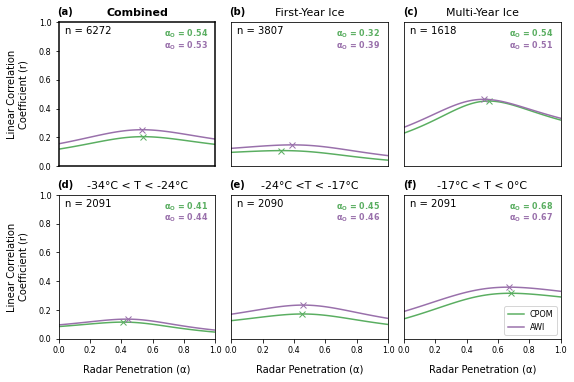

In [17]:
fig = plt.figure(figsize=(9,9))
plt.rcParams.update({'mathtext.default':  'regular' })
plt.rc('font', size=8)
spec = gridspec.GridSpec(ncols=3, nrows=3, wspace=0.1, hspace=0.2)
names = ['Combined','First-Year Ice','Multi-Year Ice',
         '-34\u00B0C < T < -24\u00B0C','-24\u00B0C <T < -17\u00B0C','-17\u00B0C < T < 0\u00B0C']
nums = ['(a)','(b)','(c)','(d)','(e)','(f)']
rs = [all_rs, all_fyi,all_myi,all_cold,all_warm,all_hot]

for c,r in enumerate(rs):
    ax = plt.subplot(spec[c])
    ax.plot(alphas/100, r['CPOM'],label = 'CPOM',color='#5aae61')
    ax.plot((np.nanargmax(r['CPOM'])/100),np.nanmax(r['CPOM']),'x',color='#5aae61')
    ax.text(0.81, 0.9, f"\u03B1$_O$ = {(np.nanargmax(r['CPOM'])/100):.2f}", ha='center',color='#5aae61',
            weight='bold',transform = ax.transAxes)       
    
    ax.plot(alphas/100, r['AWI'],label = 'AWI',color='#9970ab')
    ax.plot((np.nanargmax(r['AWI'])/100),np.nanmax(r['AWI']),'x',color='#9970ab')
    ax.text(0.81, 0.82, f"\u03B1$_O$ = {(np.nanargmax(r['AWI'])/100):.2f}", ha='center',color='#9970ab',
            weight='bold',transform = ax.transAxes)

    ax.text(0.04, 1.05,nums[c], ha='center',color='k',weight='bold',transform = ax.transAxes,fontsize=10)
    ax.text(0.04, 0.92,f"n = {ns[c]}", ha='left',color='k',transform = ax.transAxes,fontsize=10)
    
    ax.set_xlim([0,1])
    if c == 0:
        [x.set_linewidth(1.5) for x in ax.spines.values()]
        ax.set_title(names[c],weight = 'bold',fontsize=11)
    else:
        ax.set_title(names[c],fontsize=11)
    if c<3:
        ax.set_xticks([])
    if c in [1,2,4,5]:
        ax.set_yticks([])
    if c in [3,4,5]:
        ax.set_xlabel('Radar Penetration (\u03B1)',labelpad=10,fontsize=10)
    ax.set_ylim([0,1])
    if c in [0,3]:
        ax.set_ylabel('Linear Correlation\nCoefficient (r)',labelpad=10,fontsize=10)
    
    if c == 5:
        ax.legend(loc='lower right')
          
plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/Alpha Retracker/main_figs/optimal_alpha_combined.jpg',
            bbox_inches = "tight", dpi = 400)